In [2]:
#!pip install pandas_profiling

# Libraries and Global Settings

In [54]:
import pandas as pd  # work with Pandas dataframes
import numpy as np  # work with numpy arrays
from datetime import datetime # work with datetimes

import pandas_profiling # for EDA

import seaborn as sns # Visualizations 
#from sklearn import datasets
from yellowbrick.target import FeatureCorrelation # Visualization for Features Selection
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats

from sklearn import preprocessing
from sklearn.impute import KNNImputer

import warnings # Funktionalität zur Unterdrückung von Warnungen
warnings.filterwarnings('ignore')

In [4]:
%%html
<style>
table {float:left}
</style>

# Business Understanding

## Business Case Definition and Understanding

This project is part of the module "Machine Learning" (ML) at the Hochschule der Medien Stuttgart in the summer semster 2020.  
In this case we have to realize a project in the context of ML. 
The topic of this project comprises the analysis of the air quality in the center of Stuttgart, especially at the measuring point Stuttgart-Neckartor. 

## Goal Definition

The goal of this project is to analyze the air pollution caused by particulates (Feinstaub) in conjuction with other air specific and traffic based features.  
Furthermore, we would like to detemine if a prediction of the air pollution based on these features is possible.  
The use case of this prediction is to deliver valuable information for the warning system in Stuttgart. 

## Metrics Specification for Performance Measuring

The data samples consist of the target values for particulates and the features used as input parameters for the forecasting of our target values.  

| Column name | Additional information | Description |  Used As | 
| :------- | :------: | :------- | :-------  |
| Datum		 |  |  Datum | Feature | 
| Temp. (°C)	| Mittel	| Lufttemperatur|  Feature |
| Temp. (°C).1	| Max	| Lufttemperatur|  Feature |
| Temp. (°C).2	| Min	| Lufttemperatur|  Feature |
| Feuchte (%)	| Mittel	| Relative Luftfeuchte|  Feature |
| WG (m/s)	| Mittel	| Windgeschwindigkeit|  Feature |
| WG (m/s).1	| Max	| Windgeschwindigkeit|  Feature |
| WR (Grad)	| Mittel	| Windrichtung|  Feature |
| Druck (hPa)	| Mittel	| Absoluter Luftdruck|  Feature |
| Niederschlag (l/m²)	| Summe	| Niederschlag|  Feature |
| Globalstr. (W/m²)	| Mittel	| Globalstrahlung|  Feature |
| Str.-Bilanz (W/m²)	| Mittel	| Strahlungsbilanz|  Feature |
| UVA-Str. (W/m²)	| Mittel	| UV-A Strahlung|  Feature |
| UVB-Str. (W/m²)	| Mittel	| UV-B  Strahlung|  Feature |
| NO (µg/m³)	| Mittel	| Stickstoffmonoxid|  Feature |
| NO2 (µg/m³)	| Mittel	| Stickstoffdioxid|  Feature |
| O3 (µg/m³)	| Mittel	| Ozon|  Feature |
| PM10 (µg/m³)	| Mittel	| Feinstaub (PM10)| Outcome Variable |
| PM2,5 (µg/m³)	| Mittel	| Feinstaub (PM2.5)| not relevant |
| Verkehraufkommen	| Summe	| Verkehraufkommen |  Feature |



# Data Understanding

data must be gathered, accessed, understood and described. Quantitiy and qualitity of the data must be assessed on a high-level.

## Data Gathering

Air data:

In [5]:
# https://www.stadtklima-stuttgart.de/index.php?luft_messdaten_download

Traffic data:

In [6]:
# https://www.bast.de/BASt_2017/DE/Verkehrstechnik/Fachthemen/v2-verkehrszaehlung/Aktuell/zaehl_aktuell_node.html?nn=1819516&cms_detail=8440&cms_map=0

## Data Access

In [7]:
# define funktion to import each ExcelTab in one pandas dataframe
def excelImport(list_1, path_1, list_2, path_2):
    for i in list_1:
        if i == 2000:
            df = pd.read_excel(path_1, sheet_name=str(i), header=6)
            df = df.dropna(subset=['Datum'])
        else:
            df_temp = pd.read_excel(path_1, sheet_name=str(i), header=6)
            df_temp = df_temp.dropna(subset=['Datum'])
            df = df.append(df_temp, sort=False, ignore_index=True)
        #print(str(i))
    for j in list_2:
        df_temp2 = pd.read_excel(path_2, sheet_name=j, header=6)
        df_temp2 = df_temp2.rename(columns={"PM2,5 (µg/m³)": "PM2.5 (µg/m³)"})
        df_temp2 = df_temp2.dropna(subset=['Datum'])
        df = df.append(df_temp2, sort=False, ignore_index=True)
        #print(j)
    return df

In [8]:
list_1 = list(range(2000, 2020, 1))
list_2 = ["Jan. 2020", "Feb. 2020", "März 2020", "April 2020", "Mai 2020"]
path_1 = "Data/SZ-Tages-Werte-2000-2019.xlsx"
path_2 = "Data/S-Mitte-SZ-Tages-Werte-2020.xlsx"

df_air = excelImport(list_1, path_1, list_2, path_2)

In [9]:
df_air.head(5)

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,UVB-Str. (W/m²),NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³)
0,2000-01-01,3.718,5.7,2.138,86.83,1.9599,7.45,234.923,991.8,NaN,...,0.031,NaN,NaN,13.6,10.38,0.9109,NaN,NaN,NaN,NaN
1,2000-01-02,3.848,6.706,1.299,90.69,2.17291,7.891,222.511,996.9,NaN,...,0.04113,NaN,NaN,16.91,10.74,0.887,NaN,NaN,NaN,NaN
2,2000-01-03,1.463,2.706,0.4088,88.48,2.29521,6.03,220.181,996.2,NaN,...,0.02885,NaN,NaN,15.4,10.29,0.8394,NaN,NaN,NaN,NaN
3,2000-01-04,4.934,7.747,0.8828,77.37,3.57498,9.703,220.885,989.9,NaN,...,0.0351,NaN,NaN,22.43,13.42,0.7822,NaN,NaN,NaN,NaN
4,2000-01-05,6.917,10.07,2.034,83.52,2.23721,9.115,220.554,989.7,NaN,...,0.03395,NaN,NaN,16.03,14.27,1.189,NaN,NaN,NaN,NaN


In [10]:
df_air['Datum'][0]

Timestamp('2000-01-01 00:00:00')

In [11]:
df_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7457 entries, 0 to 7456
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                7457 non-null   datetime64[ns]
 1   Temp. (°C)           7331 non-null   object        
 2   Temp. (°C).1         7334 non-null   object        
 3   Temp. (°C).2         7320 non-null   object        
 4   Feuchte (%)          6987 non-null   object        
 5   WG (m/s)             7433 non-null   object        
 6   WG (m/s).1           7347 non-null   object        
 7   WR (Grad)            7433 non-null   object        
 8   Druck (hPa)          7299 non-null   object        
 9   Globalstr. (W/m²)    7283 non-null   object        
 10  UVA-Str. (W/m²)      7254 non-null   object        
 11  UVB-Str. (W/m²)      7253 non-null   object        
 12  NO (µg/m³)           6755 non-null   object        
 13  NO2 (µg/m³)          6742 non-nul

In [12]:
df_air['Datum'] = df_air['Datum'].dt.normalize()
#df_air['Datum'] = df_air['Datum'].dt.date

In [13]:
df_air.head(5)

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,UVB-Str. (W/m²),NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³)
0,2000-01-01,3.718,5.7,2.138,86.83,1.9599,7.45,234.923,991.8,NaN,...,0.031,NaN,NaN,13.6,10.38,0.9109,NaN,NaN,NaN,NaN
1,2000-01-02,3.848,6.706,1.299,90.69,2.17291,7.891,222.511,996.9,NaN,...,0.04113,NaN,NaN,16.91,10.74,0.887,NaN,NaN,NaN,NaN
2,2000-01-03,1.463,2.706,0.4088,88.48,2.29521,6.03,220.181,996.2,NaN,...,0.02885,NaN,NaN,15.4,10.29,0.8394,NaN,NaN,NaN,NaN
3,2000-01-04,4.934,7.747,0.8828,77.37,3.57498,9.703,220.885,989.9,NaN,...,0.0351,NaN,NaN,22.43,13.42,0.7822,NaN,NaN,NaN,NaN
4,2000-01-05,6.917,10.07,2.034,83.52,2.23721,9.115,220.554,989.7,NaN,...,0.03395,NaN,NaN,16.03,14.27,1.189,NaN,NaN,NaN,NaN


In [14]:
df_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7457 entries, 0 to 7456
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                7457 non-null   datetime64[ns]
 1   Temp. (°C)           7331 non-null   object        
 2   Temp. (°C).1         7334 non-null   object        
 3   Temp. (°C).2         7320 non-null   object        
 4   Feuchte (%)          6987 non-null   object        
 5   WG (m/s)             7433 non-null   object        
 6   WG (m/s).1           7347 non-null   object        
 7   WR (Grad)            7433 non-null   object        
 8   Druck (hPa)          7299 non-null   object        
 9   Globalstr. (W/m²)    7283 non-null   object        
 10  UVA-Str. (W/m²)      7254 non-null   object        
 11  UVB-Str. (W/m²)      7253 non-null   object        
 12  NO (µg/m³)           6755 non-null   object        
 13  NO2 (µg/m³)          6742 non-nul

In [15]:
df_air['Datum'][0]

Timestamp('2000-01-01 00:00:00')

Import function to import the traffic data 

In [16]:
def trafficImport(path, listYear):
    mydateparser = lambda x: pd.datetime.strptime(x, "%y%m%d")
    
    for i in listYear:
        
        path_full = path + str(i) + ".csv"    
    
        if i == 2003:
            df_traffic = pd.read_csv(path_full,
                         header=0,
                         sep=";",
                         parse_dates=['Datum'],
                         date_parser=mydateparser,
                         index_col=['Datum'])   
        
        else:
            df_traffic_temp = pd.read_csv(path_full,
                         header=0,
                         sep=";",
                         parse_dates=['Datum'],
                         date_parser=mydateparser,
                         index_col=['Datum'])
            df_traffic = df_traffic.append(df_traffic_temp, sort=False)
            
    df_traffic = df_traffic[["KFZ_R1", "KFZ_R2"]]
    df_traffic = df_traffic.resample('d').sum()
    df_traffic.loc[:,'KFZ_ges'] = df_traffic.loc[:,'KFZ_R1'].add(df_traffic.loc[:,'KFZ_R2'])
    df_traffic = df_traffic[["KFZ_ges"]] 
    return df_traffic

In [17]:
path = "Data/zst8440_"
listYear = list(range(2003, 2019, 1))

df_traffic = trafficImport(path, listYear)

In [18]:
df_traffic.tail(5)

,KFZ_ges
Datum,
2018-12-27,63079
2018-12-28,63118
2018-12-29,54339
2018-12-30,41674
2018-12-31,37776


Merge function to merge the two dataframes to one:

In [19]:
df_total = pd.merge(df_air, df_traffic, how='outer', on='Datum')

In [20]:
df_total.head()

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
0,2000-01-01,3.718,5.7,2.138,86.83,1.9599,7.45,234.923,991.8,NaN,...,NaN,NaN,13.6,10.38,0.9109,NaN,NaN,NaN,NaN,NaN
1,2000-01-02,3.848,6.706,1.299,90.69,2.17291,7.891,222.511,996.9,NaN,...,NaN,NaN,16.91,10.74,0.887,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,1.463,2.706,0.4088,88.48,2.29521,6.03,220.181,996.2,NaN,...,NaN,NaN,15.4,10.29,0.8394,NaN,NaN,NaN,NaN,NaN
3,2000-01-04,4.934,7.747,0.8828,77.37,3.57498,9.703,220.885,989.9,NaN,...,NaN,NaN,22.43,13.42,0.7822,NaN,NaN,NaN,NaN,NaN
4,2000-01-05,6.917,10.07,2.034,83.52,2.23721,9.115,220.554,989.7,NaN,...,NaN,NaN,16.03,14.27,1.189,NaN,NaN,NaN,NaN,NaN


## Data Description and Understanding

### Data Quantity

### Data Quality

**Removal of dashes and double dashes**

In [21]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7458 entries, 0 to 7457
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                7458 non-null   datetime64[ns]
 1   Temp. (°C)           7331 non-null   object        
 2   Temp. (°C).1         7334 non-null   object        
 3   Temp. (°C).2         7320 non-null   object        
 4   Feuchte (%)          6987 non-null   object        
 5   WG (m/s)             7433 non-null   object        
 6   WG (m/s).1           7347 non-null   object        
 7   WR (Grad)            7433 non-null   object        
 8   Druck (hPa)          7299 non-null   object        
 9   Globalstr. (W/m²)    7283 non-null   object        
 10  UVA-Str. (W/m²)      7254 non-null   object        
 11  UVB-Str. (W/m²)      7253 non-null   object        
 12  NO (µg/m³)           6755 non-null   object        
 13  NO2 (µg/m³)          6742 non-nul

In [22]:
df_total.loc[df_total['PM10 (µg/m³)'] == '--']

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
6222,2017-01-13,2.9,4.5,-9.4,57.5,4.9,13.8,224.4,965.63,27.3,...,NaN,NaN,45.8,NaN,NaN,0.08,-26.8,--,NaN,86737.0
6273,2017-03-05,8.6,12.8,5.7,60.7,2.8,8.4,241.5,971.63,120.2,...,0.4,9.3,54.7,NaN,NaN,1.3,36.7,--,--,57545.0
6284,2017-03-16,11.2,19.4,4.4,55.5,1.1,3.9,223.3,992.21,169.3,...,42,60.3,5.7,NaN,NaN,0,43.4,--,--,92500.0
6285,2017-03-17,13.4,20.6,8.8,52.8,2.3,7.7,231.2,983.81,137,...,18.1,29.6,34.6,NaN,NaN,0,40.1,--,--,91461.0
6286,2017-03-18,10,11.6,8.1,72.4,3,7.3,235.6,979.88,35.1,...,0.9,11.2,43.4,NaN,NaN,10.2,-14,--,--,69042.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7385,2020-03-21,5.4,11.2,3.1,81.9,2.9,7.1,61,989.83,14.1,...,1.7,13.4,9.5,NaN,NaN,13.9,-23.7,--,21.3,NaN
7386,2020-03-22,4.2,8.4,0.9,54.4,3.7,8.8,70,994.91,161.4,...,0.9,8.2,9.5,NaN,NaN,0.1,69.8,--,12.1,NaN
7393,2020-03-29,5.9,12.5,3.1,69.2,2.1,5.5,25,988.96,28.6,...,1,12.3,9.5,NaN,NaN,3.3,-21,--,--,NaN
7394,2020-03-30,3.7,7.9,0.2,48.7,2.8,8.3,211,993.51,166.2,...,1.8,15.4,9.5,NaN,NaN,0,93.4,--,--,NaN


In [23]:
df_total.replace("--", np.nan, inplace=True)

In [24]:
df_total

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
0,2000-01-01,3.718,5.700,2.1380,86.83,1.959896,7.450,234.922917,991.80,NaN,...,NaN,NaN,13.6,10.38,0.9109,NaN,NaN,NaN,NaN,NaN
1,2000-01-02,3.848,6.706,1.2990,90.69,2.172913,7.891,222.511250,996.90,NaN,...,NaN,NaN,16.91,10.74,0.8870,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,1.463,2.706,0.4088,88.48,2.295208,6.030,220.181250,996.20,NaN,...,NaN,NaN,15.4,10.29,0.8394,NaN,NaN,NaN,NaN,NaN
3,2000-01-04,4.934,7.747,0.8828,77.37,3.574979,9.703,220.885417,989.90,NaN,...,NaN,NaN,22.43,13.42,0.7822,NaN,NaN,NaN,NaN,NaN
4,2000-01-05,6.917,10.070,2.0340,83.52,2.237208,9.115,220.554167,989.70,NaN,...,NaN,NaN,16.03,14.27,1.1890,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7453,2020-05-28,17.300,21.800,12.4000,48.90,2.400000,6.100,28.000000,996.45,235.7,...,4.2,23.5,NaN,NaN,NaN,0.0,136.1,NaN,NaN,NaN
7454,2020-05-29,16.200,21.200,9.4000,44.80,2.200000,5.600,129.000000,993.43,237.9,...,2.8,18.7,NaN,NaN,NaN,0.0,105.5,NaN,NaN,NaN
7455,2020-05-30,15.900,20.600,9.3000,47.40,2.400000,7.100,27.000000,989.46,215.4,...,2.4,18.4,NaN,NaN,NaN,0.0,104.9,NaN,NaN,NaN
7456,2020-05-31,16.700,21.900,10.4000,42.70,2.000000,5.300,61.000000,988.27,258.8,...,1.6,13.0,NaN,NaN,NaN,0.0,131.8,NaN,NaN,NaN


In [25]:
df_total.loc[df_total['PM10 (µg/m³)'] == '--']

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


In [26]:
df_total.loc[df_total['PM10 (µg/m³)'] == '-'].head(5)

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
6044,2016-07-19,25.1,31.5,17.1,50.5,1.6,2.4,217.3,984.12,305.7,...,7.6,23.8,-,NaN,NaN,0.0,150.3,-,-,89889.0
6045,2016-07-20,27.6,34.7,18.8,45.6,1.6,2.7,217.6,979.71,300.2,...,5.5,21.3,-,NaN,NaN,0.0,148.4,-,-,88879.0
6361,2017-06-01,22.2,28.4,15.1,50.3,1.2,4.2,210.0,988.66,296.6,...,6.9,40.2,28.3,NaN,NaN,0.0,296.6,-,-,93576.0
6362,2017-06-02,22.9,29.3,19.8,54.4,1.3,7.0,231.0,985.61,211.0,...,5.8,42.4,33.9,NaN,NaN,0.0,211.0,-,-,92571.0
6363,2017-06-03,22.7,29.7,17.6,63.1,1.3,6.7,251.6,981.87,219.7,...,2.6,19.1,35.3,NaN,NaN,0.0,219.7,-,-,67340.0


In [27]:
df_total.replace("-", np.nan, inplace=True)

In [28]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7458 entries, 0 to 7457
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                7458 non-null   datetime64[ns]
 1   Temp. (°C)           7331 non-null   float64       
 2   Temp. (°C).1         7334 non-null   float64       
 3   Temp. (°C).2         7320 non-null   float64       
 4   Feuchte (%)          6987 non-null   float64       
 5   WG (m/s)             7433 non-null   float64       
 6   WG (m/s).1           7347 non-null   float64       
 7   WR (Grad)            7433 non-null   float64       
 8   Druck (hPa)          7299 non-null   float64       
 9   Globalstr. (W/m²)    7283 non-null   float64       
 10  UVA-Str. (W/m²)      7254 non-null   float64       
 11  UVB-Str. (W/m²)      7253 non-null   float64       
 12  NO (µg/m³)           6710 non-null   float64       
 13  NO2 (µg/m³)          6697 non-nul

In [29]:
df_total.describe()

,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),UVA-Str. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
count,7331.000000,7334.000000,7320.000000,6987.000000,7433.000000,7347.000000,7433.000000,7299.000000,7283.000000,7254.000000,...,6710.000000,6697.000000,6960.00000,3136.000000,1277.000000,6969.000000,6727.000000,5843.000000,1451.000000,5845.000000
mean,12.035986,16.741980,7.934110,66.402367,1.981501,7.621054,194.121793,984.818118,127.758414,6.877872,...,20.574591,33.648300,23.00428,6.653081,0.390354,1.430604,35.176040,20.300021,12.529251,73857.716339
std,7.451711,8.826068,6.605726,12.034543,0.728233,3.329142,61.581520,7.769937,89.669255,4.079769,...,27.214104,16.616004,14.36668,6.241966,0.386438,3.433907,64.052121,11.865320,8.875281,15191.233885
min,-11.430000,-7.732000,-14.280000,0.051950,0.600000,1.300000,2.300000,947.400000,0.855200,0.620000,...,-5.069000,-8.038000,0.00000,-3.913000,0.023830,0.000000,-501.000000,-64.060000,0.000000,26533.000000
25%,6.200500,9.690500,2.888000,57.455000,1.500000,5.197000,153.640827,980.500000,48.605000,3.500250,...,5.059250,21.830000,11.60000,1.823750,0.106500,0.000000,-6.274000,12.570000,7.100000,61707.000000
50%,12.210000,16.950000,8.041500,67.270000,1.800000,7.009000,211.135417,985.400000,110.500000,5.857500,...,10.995000,31.250000,21.24000,5.150000,0.212500,0.040000,23.090000,18.110000,10.900000,79446.000000
75%,17.800000,23.540000,13.220000,75.600000,2.300000,9.409000,234.539583,989.800000,198.000000,9.485000,...,24.927500,42.950000,31.20000,10.320000,0.599100,1.160000,73.195000,25.365000,15.650000,85504.000000
max,31.460000,39.540000,24.200000,95.030000,7.155542,24.440000,359.700000,1011.300000,422.900000,26.500000,...,345.900000,138.800000,99.93000,44.690000,2.984000,51.100000,1079.000000,211.700000,185.199375,99162.000000


A copy of the original df_total is created for later use, especially for the comparisons when dataframe is further processed (e.g handling of missing values). In particular we want to show that character of the dataset keeps unchanged.

In [30]:
df_total_original=df_total

## Exploratory Data Analysis

### EDA Preparation

In order to do a quick exploratory data analysis we use the open source Python module Pandas profiling.  
With this module we are able to create interactive statistical reports and visualizations in a web format.

In [29]:
eda=pandas_profiling.ProfileReport(df_total)
#eda
eda.to_file(output_file="AirQualityStuttgartEDA.html")

The results of the EDA can be found [here](AirQualityStuttgartEDA.html).

### Result Summary

#### Weather

##### Temperature

All three temperature variables are highly correlated because they represent the `mean`, `max` and `min` values per day.   
For our use case the `mean` values are appropriate and therefore in the following we will drop the `min` and `max` variables. 

The `missing values` of 127 will be completed in the chapter [Detection of Missing Values](#Detection-of-Missing-Values).  


##### Radiation

The four radiation parameters `Str.-Bilanz (W/m²)`, `Globalstr. (W/m²)`, `UVA-Str. (W/m²)`, and `UVB-Str. (W/m²)` are highly correlated because `UVA` and `UVB` are components of `Global Radiation` (Globalstrahlung), and all three are components of `Radiation Balance`.  

The *missing values* of 175 will be completed in the chapter [Detection of Missing Values](#Detection-of-Missing-Values).   

*Outliers* will be handled in the following chapter [Outlier Detection and Handling](#Outlier-Detection-and-Handling).  

As the four paramaters are intercorrelated we will chose one paramter during the [Features Selection](#Features-Selection).

##### Others

- *Wind* 

There are three wind specific variables. The two variables for `Wind speed` are representing mean and max values and are therefore highly correlated. 
For our use case the mean values are appropriate and therefore in the following we will drop the max variables.
The third one is representing the `Wind Direction`. This variable might have an hugh impact due to the special topography of the city Stuttgart.

The *missing values* will be completed in the chapter [Detection of Missing Values](#Detection-of-Missing-Values).   

*Outliers* will be handled in the chapter [Outlier Detection and Handling](#Outlier-Detection-and-Handling).  

As two paramaters are interconnected and there is an additial parameter for the wind direction we will select the relevant paramters during the [Features Selection](#Features-Selection).

- *Humidity, Rainfall, Pressure*

The `Rainfall` parameter is special in that way that there are many days without rain and these days are represented by zero values.  

The *missing values* will be completed in the chapter [Detection of Missing Values](#Detection-of-Missing-Values).   

*Outliers* will be handled in the chapter [Outlier Detection and Handling](#Outlier-Detection-and-Handling).  

The relevance of these two parameters will be analyzed in the chapter [Features Selection](#Features-Selection).



#### Emmissions

- *NO / NO2 / O3 / SO2 / CO*

Some parameters show some values with a negative sign.  This seems to be unplausible because these variables have units which comprise mass and volume and therefore cannot be negative.  
We assume that these negative values are false values which arose during the recordings and should be corrected. In our case we change the negative sign to positive. This is done in the chapter [Outlier Detection and Handling](#Outlier-Detection-and-Handling). 

- *PM10 & PM2.5*

Here again we have negative values which we will handle in the same way as described above.  
Particularly the PM2.5 parameter consists of few observations and therefore a completion for missing values makes no sense. 

For both areas we will do following tasks:  
The *missing values* will be completed in the chapter [Detection of Missing Values](#Detection-of-Missing-Values).   
The relevance will be analyzed in the chapter [Features Selection](#Features-Selection).

#### Traffic

There are missing values (1,613) due to missing data for the periods 2018-2020 & 2000-2002.

The *missing values* will be completed in the chapter [Detection of Missing Values](#Detection-of-Missing-Values).   

*Outliers* will be handled in the chapter [Outlier Detection and Handling](#Outlier-Detection-and-Handling).  

The relevance will be analyzed in the chapter [Features Selection](#Features-Selection).

# Data Preparation

## Detection of Missing Values

In the areas of detection and handling of missing values there is a variance of different approaches.  
One of the easiest ways is to delete the rows which contains missing values.  
In our case this approach would lead to the fact that our idea of performing a regression on the time series would not work properly.  
Therefore we chose another approach of handling missing values. 
There a different ways to complete the data set. Popular methods use imputer function to fill mean, median or most_frequent values. In our case we use a imputer functions which is based on the K-nearest neigbor algorithm and considers the context of data more accurately.

First of all in the dataframe df_total we drop the column "Datum" because the normalization function does not work on datetime data type and store it to a new dataframe df_total_woDate.  
We use the min_max_scaler to normalize the data.  
And finally we convert the normalized data represented by numpy array back to an pandas dataframe df_total_norm.

In [31]:
df_total_woDate = df_total.drop('Datum', axis=1)
x = df_total_woDate.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_total_norm = pd.DataFrame(x_scaled)

KNN Imputing is a complex method for imputing missing values using k-Nearest Neighbors, in which the KNN algorithm finds other data points similar to one with a missing value within multidimensional space. Further information can be found [here](https://scikit-learn.org/stable/modules/impute.html#knnimpute).

In [32]:
imputer = KNNImputer()
numData = imputer.fit_transform(df_total_norm)

Create a list of columns names to recover the pandas dataframe from the above created numpy array.

In [33]:
listColumns = list(df_total_woDate.columns)

Create the pandas dataframe with normalized values.

In [34]:
df_total_norm_KNN = pd.DataFrame(data=numData, columns=listColumns)

In [35]:
df_total_norm_KNN.head()

,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),UVA-Str. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
0,0.353183,0.284143,0.426663,0.913664,0.207442,0.265774,0.650876,0.694836,0.046035,0.077512,...,0.064666,0.219793,0.136095,0.294076,0.299669,0.070239,0.262878,0.273561,0.050621,0.624580
1,0.356214,0.305424,0.404860,0.954305,0.239936,0.284831,0.616148,0.774648,0.063872,0.133269,...,0.055155,0.250180,0.169218,0.301483,0.291595,0.068908,0.238530,0.277260,0.040728,0.566377
2,0.300606,0.220807,0.381726,0.931037,0.258592,0.204408,0.609629,0.763693,0.058996,0.068624,...,0.068760,0.295387,0.154108,0.292225,0.275515,0.016434,0.310873,0.304642,0.060373,0.528893
3,0.381534,0.327445,0.394044,0.814062,0.453811,0.363137,0.611599,0.665102,0.067925,0.093393,...,0.037995,0.219616,0.224457,0.356624,0.256191,0.029147,0.320451,0.273927,0.041480,0.794192
4,0.427769,0.376587,0.423960,0.878814,0.249744,0.337727,0.610672,0.661972,0.075450,0.090572,...,0.046781,0.233223,0.160412,0.374113,0.393616,0.084540,0.303405,0.279178,0.036069,0.671693


In the next step we denormalize the values:

In [36]:
numDenorm = min_max_scaler.inverse_transform(df_total_norm_KNN)
df_total_denorm_KNN  = pd.DataFrame(numDenorm, columns=listColumns)

We generate a dataframe with one column date to concat with our newly created dataframe of denormalized values.

In [37]:
df_total_Date = df_total[['Datum']]

In [38]:
df_total = pd.concat([df_total_Date, df_total_denorm_KNN], axis=1, sort=False)

In [39]:
df_total.head()

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
0,2000-01-01,3.718,5.700,2.1380,86.83,1.959896,7.450,234.922917,991.8,20.2840,...,17.6266,24.236,13.60,10.38,0.9109,3.5892,-85.6520,11.3772,9.3750,71895.6
1,2000-01-02,3.848,6.706,1.2990,90.69,2.172913,7.891,222.511250,996.9,27.8120,...,14.2886,28.698,16.91,10.74,0.8870,3.5212,-124.1220,12.3972,7.5428,67668.4
2,2000-01-03,1.463,2.706,0.4088,88.48,2.295208,6.030,220.181250,996.2,25.7540,...,19.0638,35.336,15.40,10.29,0.8394,0.8398,-9.8208,19.9480,11.1810,64946.0
3,2000-01-04,4.934,7.747,0.8828,77.37,3.574979,9.703,220.885417,989.9,29.5224,...,8.2660,24.210,22.43,13.42,0.7822,1.4894,5.3120,11.4780,7.6820,84214.4
4,2000-01-05,6.917,10.070,2.0340,83.52,2.237208,9.115,220.554167,989.7,32.6984,...,11.3496,26.208,16.03,14.27,1.1890,4.3200,-21.6198,12.9260,6.6800,75317.4


In [40]:
df_total[df_total['NO (µg/m³)']<0]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
724,2001-12-25,2.760,4.284,0.01823,76.77,6.020583,19.640,230.395833,970.4,27.81,...,-0.66740,12.550,68.53,0.000189,0.184094,0.700,4.9370,5.420,4.0736,51685.4
725,2001-12-26,1.033,2.805,-1.88300,83.90,2.271117,9.213,248.816667,971.2,24.06,...,-0.04722,23.940,54.17,0.000000,0.229522,2.190,-5.0120,8.665,6.0636,61699.6
757,2002-01-27,11.270,13.190,8.97100,68.25,6.542354,22.040,232.679167,980.8,23.07,...,-2.31900,9.448,67.52,0.943000,0.063170,2.566,0.4678,9.346,6.7130,71213.2
771,2002-02-10,7.373,9.544,5.27300,73.36,3.763167,14.940,240.356250,981.5,67.94,...,-0.07203,13.210,62.59,2.803000,0.067470,4.400,18.7000,9.582,3.1684,69450.4
784,2002-02-23,5.360,8.231,1.02900,78.43,4.348708,19.200,245.731250,972.3,58.21,...,-0.77060,12.860,64.99,1.464000,0.071960,10.160,26.6200,5.775,3.0014,67172.8
785,2002-02-24,2.773,4.773,0.97660,70.05,3.815292,13.130,243.404167,978.6,69.80,...,-0.80880,14.190,63.57,3.402000,0.072400,0.150,17.7500,10.870,3.1684,75632.6
1254,2003-06-08,24.460,32.080,18.33000,62.55,1.709381,10.340,221.373913,984.9,243.50,...,-1.35700,26.150,52.33,-1.569000,0.063430,0.070,118.2000,20.700,14.1160,42150.0
1255,2003-06-09,22.300,27.730,18.14000,55.13,1.724512,6.422,151.290087,989.4,279.30,...,-0.75830,27.620,60.19,-1.267000,0.043770,0.000,130.7000,22.930,16.0680,45150.0
1261,2003-06-15,22.280,28.400,17.40000,64.47,1.437302,6.275,220.819120,988.3,224.90,...,-0.06211,29.860,52.15,-0.568900,0.072490,0.280,116.9000,20.020,17.1760,48635.0
1264,2003-06-18,20.380,23.190,17.76000,61.97,2.956771,12.250,264.358333,987.3,276.20,...,-0.31570,30.680,66.84,-0.500200,0.053050,0.000,143.4000,33.410,5.9134,86935.0


In [41]:
df_total_original.describe()

,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),UVA-Str. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
count,7331.000000,7334.000000,7320.000000,6987.000000,7433.000000,7347.000000,7433.000000,7299.000000,7283.000000,7254.000000,...,6710.000000,6697.000000,6960.00000,3136.000000,1277.000000,6969.000000,6727.000000,5843.000000,1451.000000,5845.000000
mean,12.035986,16.741980,7.934110,66.402367,1.981501,7.621054,194.121793,984.818118,127.758414,6.877872,...,20.574591,33.648300,23.00428,6.653081,0.390354,1.430604,35.176040,20.300021,12.529251,73857.716339
std,7.451711,8.826068,6.605726,12.034543,0.728233,3.329142,61.581520,7.769937,89.669255,4.079769,...,27.214104,16.616004,14.36668,6.241966,0.386438,3.433907,64.052121,11.865320,8.875281,15191.233885
min,-11.430000,-7.732000,-14.280000,0.051950,0.600000,1.300000,2.300000,947.400000,0.855200,0.620000,...,-5.069000,-8.038000,0.00000,-3.913000,0.023830,0.000000,-501.000000,-64.060000,0.000000,26533.000000
25%,6.200500,9.690500,2.888000,57.455000,1.500000,5.197000,153.640827,980.500000,48.605000,3.500250,...,5.059250,21.830000,11.60000,1.823750,0.106500,0.000000,-6.274000,12.570000,7.100000,61707.000000
50%,12.210000,16.950000,8.041500,67.270000,1.800000,7.009000,211.135417,985.400000,110.500000,5.857500,...,10.995000,31.250000,21.24000,5.150000,0.212500,0.040000,23.090000,18.110000,10.900000,79446.000000
75%,17.800000,23.540000,13.220000,75.600000,2.300000,9.409000,234.539583,989.800000,198.000000,9.485000,...,24.927500,42.950000,31.20000,10.320000,0.599100,1.160000,73.195000,25.365000,15.650000,85504.000000
max,31.460000,39.540000,24.200000,95.030000,7.155542,24.440000,359.700000,1011.300000,422.900000,26.500000,...,345.900000,138.800000,99.93000,44.690000,2.984000,51.100000,1079.000000,211.700000,185.199375,99162.000000


In [42]:
df_total.describe()

,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),UVA-Str. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
count,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,...,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000
mean,12.037186,16.741162,7.921511,66.493022,1.981211,7.645979,194.085750,984.837622,127.081256,6.886143,...,20.622069,33.543177,22.987206,6.555690,0.455946,1.429776,35.744829,19.559665,12.575459,73491.406081
std,7.414490,8.784031,6.567150,11.891172,0.727090,3.329761,61.500193,7.725808,89.175475,4.045396,...,26.771205,16.139952,14.077765,4.880320,0.296478,3.356878,63.374152,11.047138,6.227805,13980.740621
min,-11.430000,-7.732000,-14.280000,0.051950,0.600000,1.300000,2.300000,947.400000,0.855200,0.620000,...,-5.069000,-8.038000,0.000000,-3.913000,0.023830,0.000000,-501.000000,-64.060000,0.000000,26533.000000
25%,6.259250,9.750500,2.931250,57.700000,1.500000,5.197000,153.713579,980.585000,48.562500,3.536250,...,5.287000,22.260000,11.840000,3.107445,0.226937,0.000000,-6.246750,12.480000,8.411100,63845.250000
50%,12.205000,16.930000,8.002000,67.390000,1.800000,7.009000,211.071147,985.400000,109.900000,5.909400,...,11.165000,31.175000,21.465000,5.959850,0.393567,0.060000,23.830000,17.305000,11.460000,77316.500000
75%,17.730000,23.500000,13.170000,75.560000,2.300000,9.458000,234.489428,989.800000,196.800000,9.458750,...,24.995000,42.510000,30.887500,9.152800,0.625345,1.270000,74.417500,24.117500,15.500000,84217.500000
max,31.460000,39.540000,24.200000,95.030000,7.155542,24.440000,359.700000,1011.300000,422.900000,26.500000,...,345.900000,138.800000,99.930000,44.690000,2.984000,51.100000,1079.000000,211.700000,185.199375,99162.000000


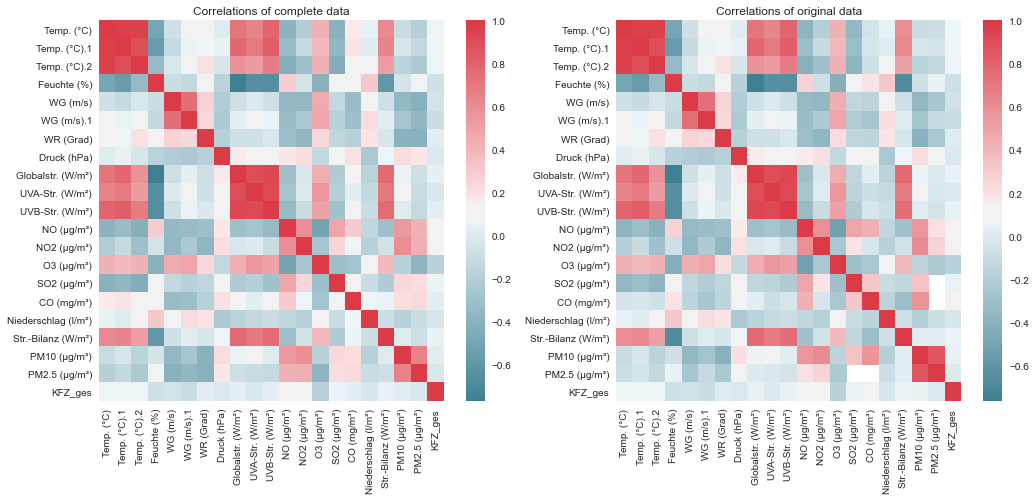

In [43]:
corr_total = df_total.corr()
corr_total_original = df_total_original.corr()

fig, ax = plt.subplots(1, 2, figsize=(17, 7))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_total, cmap=colormap, annot=False, fmt=".2f", ax=ax[0]).set_title("Correlations of complete data")
sns.heatmap(corr_total_original, cmap=colormap, annot=False, fmt=".2f", ax=ax[1]).set_title("Correlations of original data")
plt.show()

We see that the data "characters" and patterns after completing missing data has not changed significantly so that we can continue with the completed data.

In the following we see that the time gaps for particultes were filled by the imputer function.

First we show the whole period 2000-2020.

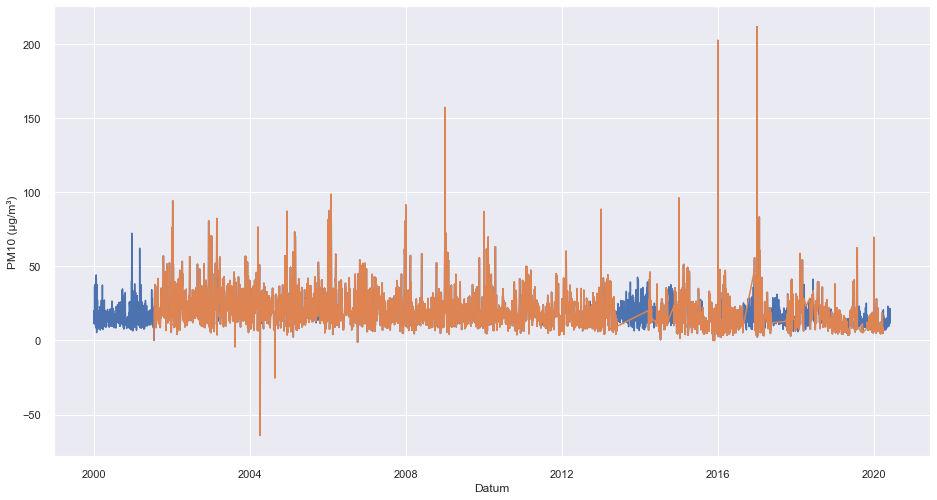

In [44]:
sns.set(rc={'figure.figsize':(15.7,8.27)})

ax=sns.lineplot(x="Datum", y="PM10 (µg/m³)", data=df_total)
ax=sns.lineplot(x="Datum", y="PM10 (µg/m³)", data=df_total_original)

We can zoom in for period starting on 01 January 2013.

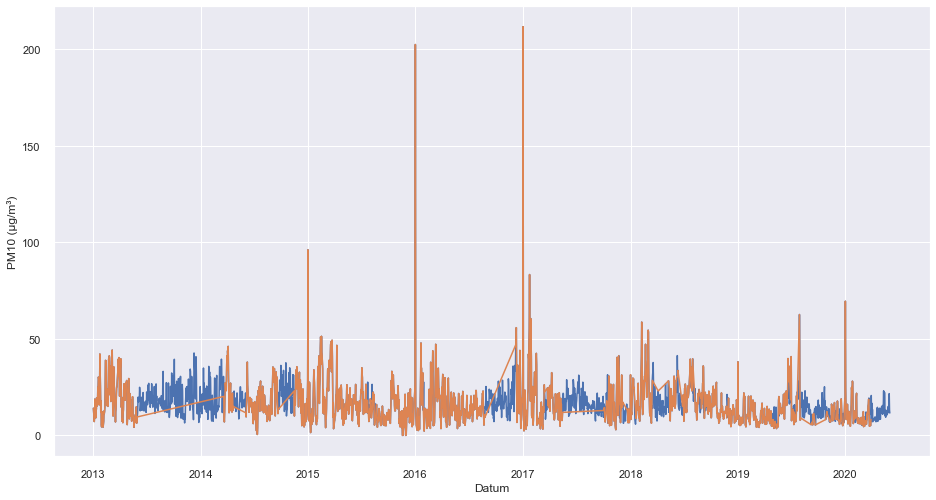

In [45]:
sns.set(rc={'figure.figsize':(15.7,8.27)})

ax=sns.lineplot(x="Datum", y="PM10 (µg/m³)", data=df_total[df_total["Datum"] > '2013-01-01 00:00:00'])
ax=sns.lineplot(x="Datum", y="PM10 (µg/m³)", data=df_total_original[df_total_original["Datum"] > '2013-01-01 00:00:00'])

Further zoom in for period 2018-2019.

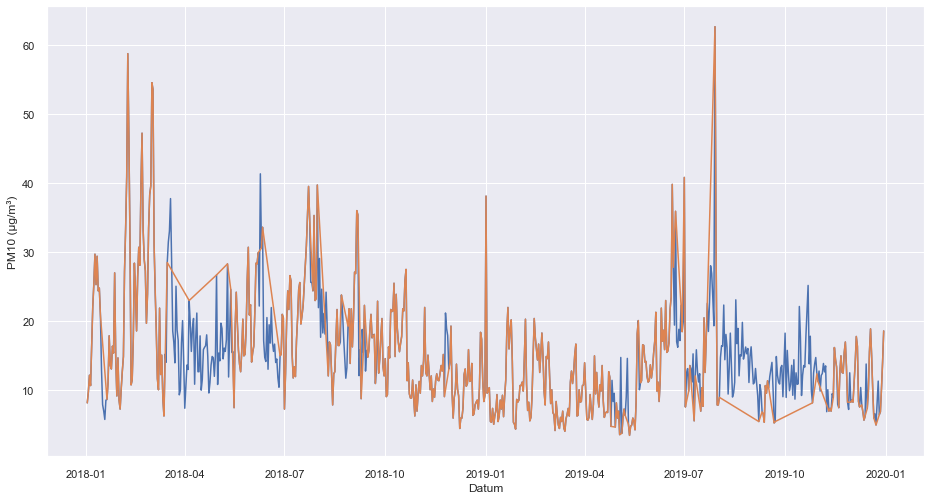

In [46]:
sns.set(rc={'figure.figsize':(15.7,8.27)})

ax=sns.lineplot(x="Datum", y="PM10 (µg/m³)", data=df_total[(df_total["Datum"] > '2018-01-01 00:00:00')&(df_total["Datum"] < '2019-12-31 00:00:00')])
ax=sns.lineplot(x="Datum", y="PM10 (µg/m³)", data=df_total_original[(df_total_original["Datum"] > '2018-01-01 00:00:00')&(df_total_original["Datum"] < '2019-12-31 00:00:00')])

We also plot and analyze the data for traffic. Here we realized that the imputting method does not work optimally for this attribute. In the period 2000-2002 we see an decreasing trend of the traffic data. We would expect an increase trend in analogy to the real data 2003-2018. The populated period at the end of the time series also seem to to decrease. Here we also would expect an increase behaviour.  
In this case we would chose another imputing method based on a linear regression approach. Due to the restricted time and the higher focus an Machine Learning we will continue with this data though. 

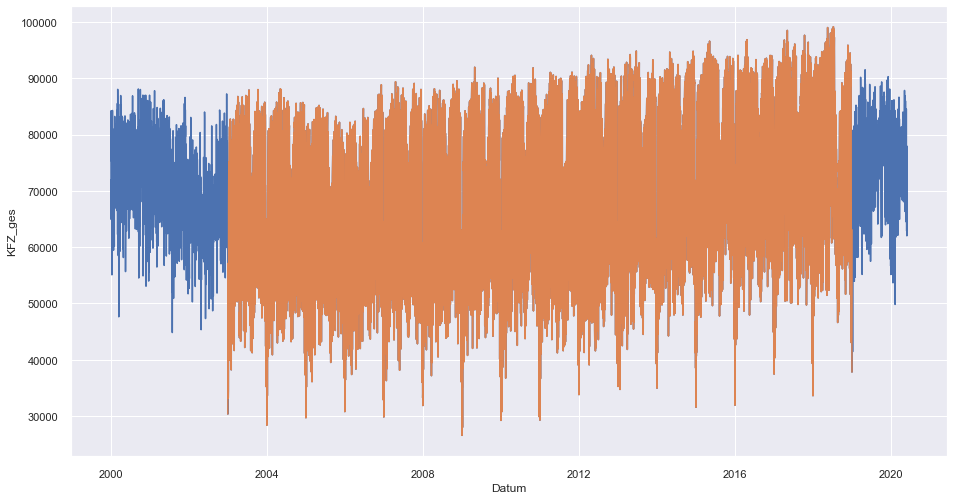

In [47]:
sns.set(rc={'figure.figsize':(15.7,8.27)})

ax=sns.lineplot(x="Datum", y="KFZ_ges", data=df_total)
ax=sns.lineplot(x="Datum", y="KFZ_ges", data=df_total_original)

## Outlier Detection and Handling

## Features Selection

The goals of the feature selections are:
- Eliminate redundancies and correlations of different features, e.g. at the level of temperature and radiation parameters
- Reduce computational time / cost
- Improve the prediction accuracy 
- Produce a more interpretable model

We also realized that for some features a further feature processing would be helpful. For example the feature `Wind Direction` could be transformed in 8 cardinal points like North-East, South, South-West etc. Due to the restricted time and the higher focus an Machine Learning we will continue with this data. 

Basesd on Scikit-Learn the feature importance is calculated with `sklearn.feature_selection.mutual_info_regression` (more information can be found here on [Scikit](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html?highlight=mutual_info_regression#sklearn.feature_selection.mutual_info_regression))
The visualization is generated with the help of [yellowbrick](https://www.scikit-yb.org/en/latest/api/target/feature_correlation.html).

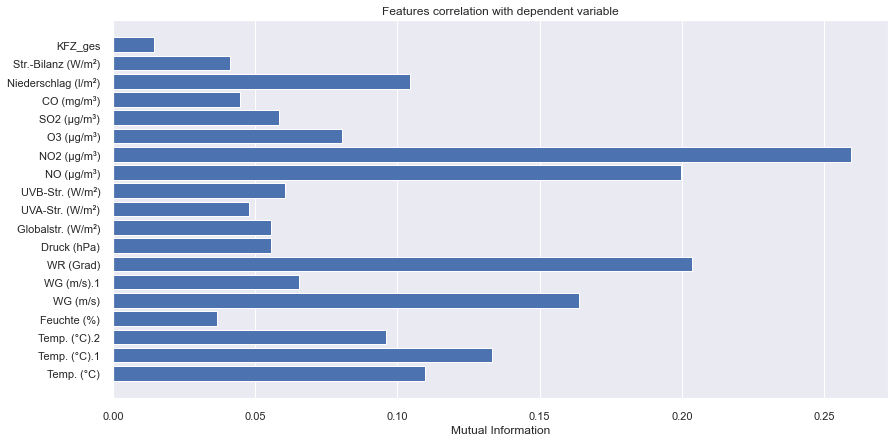

In [359]:
X, y = df_total.drop(['Datum','PM10 (µg/m³)','PM2.5 (µg/m³)'], axis=1).to_numpy(), df_total['PM10 (µg/m³)'].to_numpy()

# Create a list of the feature names
features = np.array(list(df_total.drop(['Datum','PM10 (µg/m³)','PM2.5 (µg/m³)'], axis=1)))

# Create a list of the discrete features
discrete = [False for _ in range(len(features))]
discrete[1] = True

# Instantiate the visualizer
visualizer = FeatureCorrelation(method='mutual_info-regression', labels=features, size=(1000, 500))

visualizer.fit(X, y, discrete_features=discrete, random_state=0)
visualizer.show()

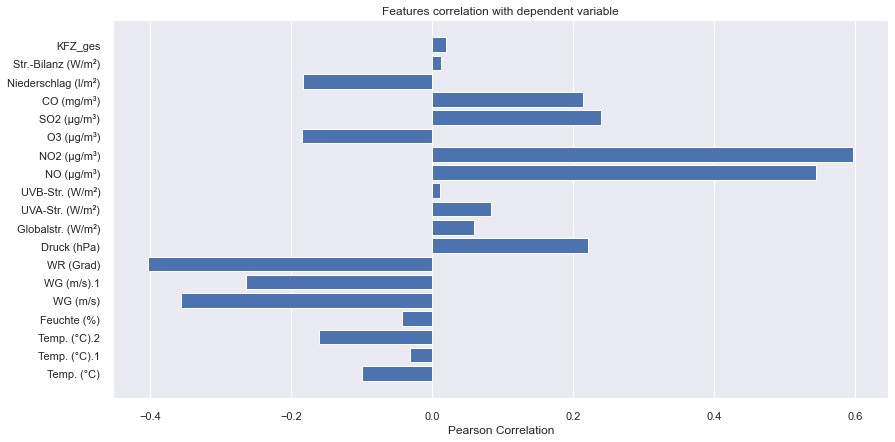

In [57]:
X, y = df_total.drop(['Datum','PM10 (µg/m³)','PM2.5 (µg/m³)'], axis=1).to_numpy(), df_total['PM10 (µg/m³)'].to_numpy()

# Create a list of the feature names
features = np.array(list(df_total.drop(['Datum','PM10 (µg/m³)','PM2.5 (µg/m³)'], axis=1)))

# Create a list of the discrete features
discrete = [False for _ in range(len(features))]
discrete[1] = True

# Instantiate the visualizer
visualizer = FeatureCorrelation(method='pearson', labels=features, size=(1000, 500))

visualizer.fit(X, y)
visualizer.show()

In case of temperature, we only chose the `Temperature (mean)` value (as described above).  
In case of radiation we only keep the `Global radiation` as the other are connected to this parameter.  
Other than expected the `Number of vehicals` has the lowest impact and therefore is droped out.  
In the conext of wind the two parameters `Wind speed (mean)` and `Wind direction` are kept.  

Finally we drop all unnecessary features and keep only those ones that have a significant importance. 

# Modeling

## Data Preparation

Definition of Sampling Rates

### Data Scaling and Normalization

### Split Data into Training and Validation Samples

## Alogrithms Selection

## Baseline Models

## Deep Learning Models

## Hyperparamters Optimization

## Evaluation

### Model Evaluation (Performance)

#### Training Phase

#### Testing Phase

# Projekt Evaluation

# Deployment

In the first phase of CRISP the overall business-case, which shall be supported by the data mining process must be clearly defined and understood. Then the goal of the data mining project itself must be defined. This includes the specification of metrics for measuring the performance of the data mining project.

In the second phase data must be gathered, accessed, understood and described. Quantitiy and qualitity of the data must be assessed on a high-level.

In the third phase data must be investigated and understood more thoroughly. Common means for understanding data are e.g. visualization and the calculation of simple statistics. Outliers must be detected and processed, sampling rates must be determined, features must be selected and eventually be transformed to other formats.

In the modelling phase various algorithms and their hyperparameters are selected and applied. Their performance on the given data is determined in the evaluation phase.

The output of the evaluation is usually fed back to the first phases (business- and data-understanding). Applying this feedback the techniques in the overall process are adapted and optimized. Usually only after several iterations of this process the evaluation yields good results and the project can be deployed.